# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 9: Decision Trees (Part 1 of 2): Classification, Regression, Bagging, Random Forests

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors:** Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Lab Instructors:** Chris Tanner and Eleni Kaxiras<br/>
**Authors:** Kevin Rader, Rahul Dave, Chris Tanner

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
#HTML(styles)

## Learning Goals

The goal of this lab is for students to:

<ul>
  <li>Understand where Decision Trees fit into the larger picture of this class and other models</li>
  <li>Understand what Decision Trees are and why we would care to use them</li>
  <li>How decision trees work</li>
  <li>Feel comfortable running sklearn's implementation of a decision tree</li>
   <li>Understand the concepts of bagging and random forests</li>
</ul>  

In [2]:
# imports
%matplotlib inline
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns

## Background

Let's do a high-level recap of what we've learned in this course so far:

Say we have input data $X = (X_1, X_2, ..., X_n)$ and corresponding class labels $Y = (Y_1, Y_2, ..., Y_n)$ where $n$ represents the number of observations/instances (i.e., unique samples). Much of statistical learning concerns trying to model this relationship between our data's $X$ and $Y$. In particular, we assert that the $Y$'s were produced/generated by some underlying function $f(X)$, and that there is inevitably some noise and systematic, implicit bias and error $\epsilon$ that cannot be captured by any $f(X)$. Thus, we have:

$Y = f(X) + \epsilon$

Statistical learning concerns either **prediction** or **inference**:

**Prediction:** concerns trying to learn a function $\hat{f}(X)$ that is as close as possible to the true function $f(X)$. This allows us to estimate $Y$ values for any new input data $X$.

**Inference:** concerns trying to understand/model the _relationship_ between $X$ and $Y$, effectively learning how the data was generated.

Independent of this, if you have access to gold truth labels $Y$, and you make use of them for your modelling, then you are working on a **supervised** learning task. If you do not have or make use of $Y$ values, and you are only concerned with the input data $X$, you are working on an **unsupervised** learning task.

<br>
<div class="exercise"><b>Q1:</b> Using the above terms, what types of problems are linear regression, logistic regression, and PCA?</div>

Linear and logistic regression are supervised prediction problems. PCA is a supervised problem of reduction of dimensionality.

<br>
<div class="exercise"><b>Q2:</b> What is a decision tree? Why do we care to make a decision tree?</div>

A decision tree is a classifier in form of a binary three (graph YES x NO).

## Understanding Decision Trees

My goal is for none of the topics we learn in this class to seem like nebulus concepts or black-boxes of magic. In this course, it's important to understand the models that you can use to help you with your data, and this includes not only knowing how to invoke these as tools within Python libraries (e.g., ``sklearn``, ``statsmodels``), but to have an understanding of what each model is actually doing 'under the hood' -- how it actually works -- as this provides insights into why you should use one model vs another, and how you could adjust models and invent new ones!


### Entropy (aka Uncertainty)

Remember, in the last lab, we mentioned that in data science and machine learning, our models are often just finding patterns in the data. For example, for classification, it is best when our data is separable by their $Y$ class lables (e.g., cancerous or benign). That is, hopefully the $X$ values for one class label (e.g., cancerous) is disjoint and separated from the $X$ values that correspond to another class label (e.g., benign). If so, our model would be able to easily discern if a given, new piece of data corresponds to the cancerous label or benign label, based on its $X$ values. If the data is not easily separable (i.e., the $X$ values corresponding to cancer looks very similar to $X$ values corresponding to benign), then our task is difficult and perhaps impossible. Along these lines, we can measure this element in terms of how messy/confusable/_uncertain_ a collection of data is.

In the 1870s, physicists introduced a term ``Gibbs Entropy``, which was useful in statistical thermodynamics, as it effectively measured uncertainty. By the late 1920s, the foundational work in Information Theory had begun; pioneers John von Neumann and Claude Shannon conducted phenomenal work which paved the way for computation at large -- they heavily influenced the creation of computer science, and their work is still seen in modern day computers. Information theory concerns [entropy.](https://en.wikipedia.org/wiki/Entropy_(information_theory)) So let's look at an example to concretely address what entropy is (the information theoretic version of it).

Say that we have a fair coin $X$, and each coin fliip is an observation. The coin is equally likely to yield heads or tails. The uncertainty is very high. In fact, it's the highest possible, as it's truly a 50/50 chance of either. Let $H(X)$ represent the entropy of $X$. Per the graphic below, we see that entropy is in fact highest when the probabilities of a 2-class variable are a 50/50 chance.

<div>
<img src="coin_flip.png" width="300"/>
</div>

If we had a cheating coin, whereby it was guaranteed to always be a head (or a tail), then our entropy would be 0, as there is no **uncertainty** about its outcome. Again, this term, entropy, predates decision trees and has vast applications. Alright, so we can see what entropy is measuring (the uncertainty), but how was it actually calculated?

#### Definition:
Entropy factors in _all_ possible values/classes of a random variable (log base 2):
<div>
<img src="entropy_definition.svg" width="250"/>
</div>

#### Fair-Coin Example
In our fair coin example, we only have 2 classes, both of which have a probability of 1/2. So, to calculate the overall entropy of the fair coin, we have Entropy(1+, 1-) =

$$
\begin{align}
H(X) &= -1 * (P(coin=heads)*log(P(coin=heads)) + P(coin=tails)*log(P(coin=tails))) \\
&= -1 * (\frac{1}{2}log(\frac{1}{2}) + \frac{1}{2}log(\frac{1}{2})) \\ 
&= -1 * (\frac{1}{2}*-1) + \frac{1}{2}*-1) \\
& = -1 * (-\frac{1}{2} + -\frac{1}{2}) \\
& = -1*-1 = 1
\end{align}
$$

### Worked Example

Let's say that we have a small, 14-observation dataset that concerns if we will play tennis on a given day or not (Play Tennis will be our output $Y$), based on 4 features of the current weather:
<p>
<div>
<img src="play_tennis_dataset.png" width="500"/>
</div>
<p>
Completely independent of the features, we can calculate the overall entropy of playing tennis, Entropy for (9+, 5-) examples =

<p>
<center>
$H(X) = -1 * (P$(play_tennis=yes)*log(P(play_tennis=yes)) + P(play_tennis=no)*log(P(play_tennis=no)))
</center>

<p>
<center>
$ = -\frac{9}{14}log(\frac{9}{14}) - \frac{5}{14}log(\frac{5}{14}) = 0.94$
</center>
    
Okay, **0.94** is pretty horrible, as it's close to 1, which is the worst possible value. This means that a priori, if we use no features, it's hard to predict if we will play tennis or not. There's a lot of uncertainty (aka entropy). To improve this, could we segment our data in such a way that it's more clear if we will play tennis or not (i.e., by more clear, I mean we will have lower uncertainty... lower entropy).

Let's start with looking at the ``Wind`` feature. There are 2 possible values for the Wind attribute, **weak** or **strong.** If we were to look at the subset of data that has weak wind, we see that there are 8 data samples (6 are 'Yes' for Play Tennis, 2 have 'No' for Play Tennis). Hmm, so if we know that the Wind is weak, it helps inform us that there's a 6/8 (75%) chance that we will Play Tennis. Let's put this in terms of entropy:

When we look at ONLY the Wind is Weak subset of data, we have a Play Tennis entropy for (6+, 2-) examples, which calculates to:
<p>
<center>
$H(X) = -1 * (P($play_tennis=yes$)*log(P$(play_tennis=yes$)) + P($play_tennis$=$no$)*log(P($play_tennis$=no)))$
</center>

<p>
<center>
$ = -\frac{6}{8}log(\frac{6}{8}) - \frac{2}{8}log(\frac{2}{8}) = 0.811$
</center>

A value of 0.811 may seem sadly high, still, but our calculation was correct. If you reference the figure above that shows the entropy of a fair coin, we see that having a probability of 75% does in fact yield an entropy of 0.811.

We're only looking at a subset of our data though (the subset for Wind is Weak). We now need to look at the rest of our data (the subset for Wind is Strong). When the Wind is Strong, we have 6 data points: 3 have Play Tennis is Yes, and 3 are No). In short-hand notation, we have (3+, 3-), which is a 0.5 probability, and we know already that this yields an Entropy of 1.

When looking at this possible division of separating our data according to the value of Wind, the hope was that we'd have very low entropy in each subset of data. Imagine if the Wind attribute perfectly aligned with Playing Tennis or not (the values were identical). In that case, we would have an Entropy of 0 (no uncertainty), and thus, it would be INCREDIBLY useful to predict playing tennis or not based on the Wind attribute (it would tell us the exact answer).

We saw that the Wind attribute didn't yield an entropy of 0; its two classes (weak and strong) had an entropy of 0.811 and 1, respectively. Is Wind a useful feature for us then? In order quantitatively measure its usefulness, we can use the entropy to calculate ``Information Gain``, which we saw in Lecture 15 on Slide 40:

$$Gain(S) = H(S) - \sum_{i}\frac{|S_{i}|}{|S|}\cdot H(S_{i})$$

Let $S$ represent our current data, and each $S_{i}$ is a subset of the data split according to each of the possible values. So, when considering splitting on Wind, our Information Gain is:

<p>
<center>
$Gain($alldata)$ = H($alldata$) - \frac{|S_{windweak}|}{|S|}H(S_{windweak}) - \frac{|S_{windstrong}|}{|S|}H(S_{windstrong})$
</center>

<p>
<center>
$ = 0.94 - \frac{8}{14}0.811 - \frac{6}{14}1.00 = 0.048$
</center>

Okay, using Wind as a feature to split our data yields an Information Gain of 0.048. That looks like a low value. We want a high value because gain is good (we want to separate our data in a way that the increases our information). Is 0.048 bad? It all depends on the dataset.

<p>
<div class="exercise"><b>Q3:</b> Using our entire 14-observation dataset, calculate the Information Gain for the other 3 remaining features (Outlook, Temperature, Humidity). What are their values and which ones gives us the most information gain?</div>

In [10]:
from numpy import log2

In [13]:
# %load solutions/q3.txt
outlook_entropy_sunny = - 3/5*log2(3/5) - 2/5*log2(2/5)
outlook_entropy_overcast = 0
outlook_entropy_runny = - 3/5*log2(3/5) - 2/5*log2(2/5)

print(0.94 - 5/14*outlook_entropy_sunny - 4/14*outlook_entropy_overcast - 5/14*outlook_entropy_runny)

0.24646386110380814


<div class="exercise"><b>Q4:</b> Now that we know which feature provides the most information gain, how should we use it to construct a decision tree? Let's start the construction of our tree and repeat the process of Q3 one more time.</div>

The root should be the higher gain, and separate it in all categories. For each category, we look only at that subset. After we select the second feature with higher gain inside this subset. 

<div class="exercise"><b>Q5:</b> When should we stop this process?</div>

If the entropy is 0, we should stop. If the depth is more the $N$, we could stop. If we no features rest too. 

<div class="exercise"><b>Q6:</b> Should we standardize or normalize our features? Both? Neither?</div>

It's not necessary because the decision cut in a specific value, not based on the data size. 

<div class="exercise"><b>Q7:</b> What if we have outliers? How sensitive is our Decision Tree to outliers? Why?</div>

It's not sensitive, cause of the size of the data doesn't influence the cuts.

#### Connection to Lecture
In Lecture 16, Pavlos started by presenting the tricky graph below which depicts a dataset with just 2 features: longitude and latitude.

<div>
<img src="green_white_data.png" width="300"/>
</div>

By drawing a straight line to separate our data, we would be doing the same exact process that we are doing here with our Play Tennis dataset. In our Play Tennis example, we are trying to segment our data into bins according to the possible _categories_ that a feature can be. In the lecture example (pictured above), we have continuous data, not discrete categories, so we have an infinite number of thresholds by which to segment our data.

<p>
<div class="exercise"><b>Q8:</b> How is it possible to segment continuous-valued data, since there are infinite number of possible splits? Do we try 1,000,000 possible values to split by? 100?</div>

No, of course not. We could make histogram counting the number of points in the interaval. When it changes (it should exist some thresh), we insert this node in the three.

### Summary:

To build a decision tree:
<ul>
  <li>Start with an empty tree and some data $X$</li>
  <li>Decide what your splitting criterion will be (e.g., Gini, Entropy, etc)</li>
  <li>Decide what your what your stopping criterion will be, or if you'll develop a large tree and prune (pruning is covered in Lecture 15, slides 41 - 54)</li>
  <li>Build the tree in a greedy manner, and if you have multiple hyperparameters, use cross-validation to determine the best values</li>
</ul>  


## Sklearn's Implementation

Our beloved `sklearn` library has implementations of DecisionTrees, so let's practice using it.

First, let's load our Play Tennis data `(../data/play_tennis.csv")`:

In [16]:
tennis_df = pd.read_csv("../data/play_tennis.csv")
tennis_df = pd.get_dummies(tennis_df, columns=['outlook', 'temp', 'humidity', 'windy'])
tennis_df

,play,outlook_overcast,outlook_rainy,outlook_sunny,temp_cool,temp_hot,temp_mild,humidity_high,humidity_normal,windy_False,windy_True
0,no,0,0,1,0,1,0,1,0,1,0
1,no,0,0,1,0,1,0,1,0,0,1
2,yes,1,0,0,0,1,0,1,0,1,0
3,yes,0,1,0,0,0,1,1,0,1,0
4,yes,0,1,0,1,0,0,0,1,1,0
5,no,0,1,0,1,0,0,0,1,0,1
6,yes,1,0,0,1,0,0,0,1,0,1
7,no,0,0,1,0,0,1,1,0,1,0
8,yes,0,0,1,1,0,0,0,1,1,0
9,yes,0,1,0,0,0,1,0,1,1,0


Normally, in real situations, we'd perform EDA. However, for this tiny dataset, we see there are no missing values, and we do not care if there is collinearity or outliers, as Decision Trees are robust to such.

In [17]:
# separate our data into X and Y portions
x_train = tennis_df.iloc[:, tennis_df.columns != 'play'].values
y_train = tennis_df['play'].values

We can build a DecisionTree classifier as follows:

In [18]:
dt = DecisionTreeClassifier().fit(x_train, y_train)

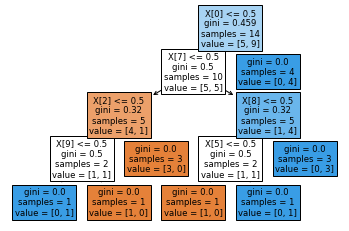

In [19]:
tree_vis = tree.plot_tree(dt, filled=True)

<p>
<div class="exercise"><b>Q9:</b> Is this tree identical to what we constructed above? If not, what differs in sklearn's implementation?</div>

It is optimizing the Gini, not Entropy as we do. And the implementation is not write for categorical data. 

In the above example, we did not use the tree to do any classification. Our data was too small to consider such.

Let's turn to a different dataset:

## 2016 Election Data
We will be attempting to predict the presidential election results (at the county level) from 2016, measured as 'votergap' = (trump - clinton) in percentage points, based mostly on demographic features of those counties.  Let's quick take a peak at the data:

In [20]:
elect_df = pd.read_csv("../data/county_level_election.csv")
elect_df.head()

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


In [21]:
# split 80/20 train-test
X = elect_df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
response = elect_df['votergap']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,response,test_size=0.2)

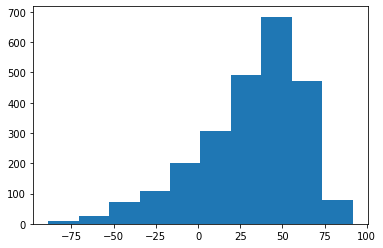

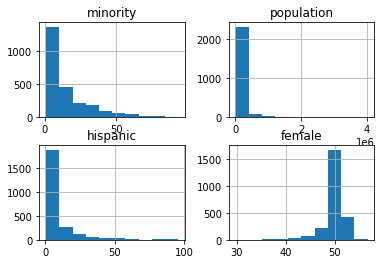

In [22]:
plt.hist(ytrain)
Xtrain.hist(column=['minority', 'population','hispanic','female']);

In [23]:
print(elect_df.shape)
print(Xtrain.shape)
print(Xtest.shape)

(3066, 18)
(2452, 12)
(614, 12)


## Regression Trees

We will start by using a simple Decision Tree Regressor to predict votergap. We'll run a few of these models without any cross-validation or 'regularization', just to illustrate what is going on.

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

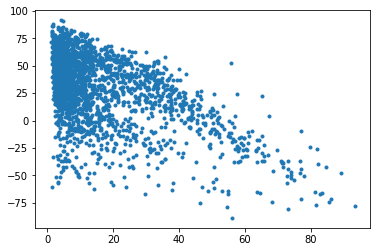

In [24]:
from sklearn.tree import DecisionTreeRegressor
x = Xtrain['minority'].values
o = np.argsort(x)
x = x[o]
y = ytrain.values[o]
plt.plot(x,y, '.');

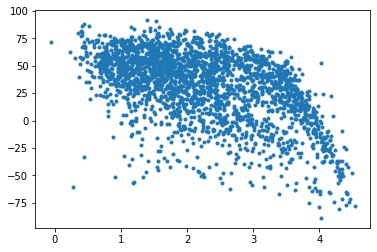

In [25]:
plt.plot(np.log(x),y, '.'); # log scale

<p>
<div class="exercise"><b>Q10:</b> Which of the two versions of 'minority' would be a better choice to use as a predictor for prediction?</div>


It should be the same.

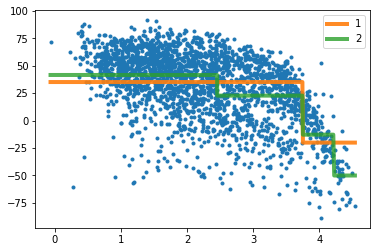

In [26]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [1,2]:
    dtree = DecisionTreeRegressor(max_depth=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=1-i/10, lw=4)
plt.legend();

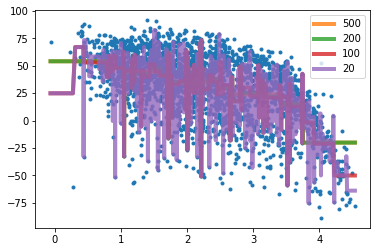

In [27]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [500,200,100,20]:
    dtree = DecisionTreeRegressor(min_samples_split=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=0.8, lw=4)
plt.legend();

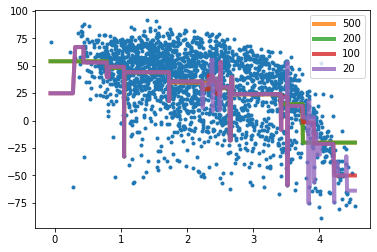

In [28]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [500,200,100,20]:
    dtree = DecisionTreeRegressor(max_depth=6, min_samples_split=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=0.8, lw=4)
plt.legend();

In [29]:
#let's also include logminority as a predictor going forward
xtemp = np.log(Xtrain['minority'].values)
Xtrain = Xtrain.assign(logminority = xtemp)
Xtest = Xtest.assign(logminority = np.log(Xtest['minority'].values))
Xtrain.head()


,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,logminority
2759,4273,60.951,3.654,49.604,6.0,60435,24.4,17.8,21.8,26.6,1.6,295.6,1.295822
2526,93072,2.317,6.604,50.554,3.6,55320,8.1,27.8,21.8,28.5,43.8,276.8,1.887676
1821,2420,2.147,2.683,48.882,2.5,49159,7.9,24.5,22.3,31.4,1.6,242.4,0.986936
1619,27337,2.608,33.415,51.915,7.2,40975,19.6,16.8,34.1,37.4,23.8,233.7,3.509005
144,26441,4.042,5.439,50.182,4.6,50745,8.3,21.0,29.3,33.8,30.8,132.3,1.693595


Ok with this discussion in mind, lets improve this model by Bagging.

## Bootstrap-Aggregating (called Bagging)

<p>
<div class="exercise"><b>Q11:</b> Class poll: When did the movie Titanic come out?</div>


The basic idea:
- A Single Decision tree is likely to overfit.
- So lets introduce replication through Bootstrap sampling.
- **Bagging** uses bootstrap resampling to create different training datasets. This way each training will give us a different tree.
- Added bonus: the left off points can be used to as a natural "validation" set, so no need to 
- Since we have many trees that we will **average over for prediction**, we can choose a large `max_depth` and we are ok as we will rely on the law of large numbers to shrink this large variance, low bias approach for each individual tree.

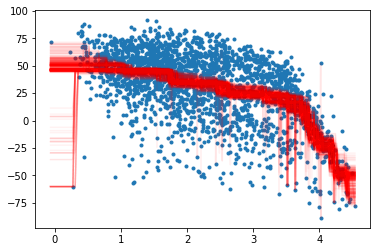

In [30]:
from sklearn.utils import resample

ntrees = 500
estimators = []
R2s = []
yhats_test = np.zeros((Xtest.shape[0], ntrees))

plt.plot(np.log(x),y,'.')
for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=3)
    boot_xx, boot_y = resample(Xtrain[['logminority']], ytrain)
    estimators = np.append(estimators,simpletree.fit(boot_xx, boot_y))
    R2s = np.append(R2s,simpletree.score(Xtest[['logminority']], ytest))
    yhats_test[:,i] = simpletree.predict(Xtest[['logminority']])
    plt.plot(np.log(x), simpletree.predict(np.log(x).reshape(-1,1)), 'red', alpha=0.05)

In [31]:
yhats_test.shape

(614, 500)

**Exercise 2**

1. Edit the code below (which is just copied from above) to refit many bagged trees on the entire xtrain feature set (without the plot...lots of predictors now so difficult to plot). 
2. Summarize how each of the separate trees performed (both numerically and visually) using $R^2$ as the metric.  How do they perform on average?
3. Combine the trees into one prediction and evaluate it using $R^2$.
4. Briefly discuss the results.  How will the results above change if 'max_depth=4' is increased?  What if it is decreased?

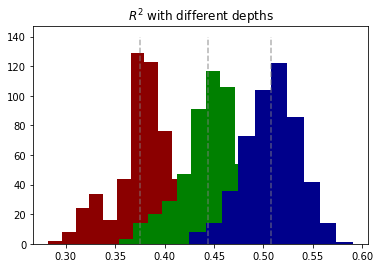

In [41]:
from sklearn.metrics import r2_score


ntrees = 500
estimators = []
R2s = np.zeros((ntrees, 3))
yhats_test = np.zeros((3, Xtest.shape[0], ntrees))

for i in range(ntrees):
    for d in [2,3,4]: 
        dtree = DecisionTreeRegressor(max_depth=d)
        boot_xx, boot_y = resample(Xtrain, ytrain)
        estimators = np.append(estimators,dtree.fit(boot_xx, boot_y))
        R2s[i, d-2] = dtree.score(Xtest, ytest)
        yhats_test[d-2,:,i] = dtree.predict(Xtest)

colors = ['darkred', 'green', 'darkblue']
for d in [0,1,2]:
    plt.hist(R2s[:,d], label = 'depth='+str(d), color = colors[d])
    plt.vlines(np.mean(R2s[:,d]), ymin = 0, ymax = 140, linestyle = '--', color = 'grey', alpha = 0.6)
plt.title(r'$R^2$ with different depths')
plt.show()

#### Your answer here

WHen we increase the depth, the higher the R2 gets. This can be caused by an overfitting. 

<hr style='height:2px'>

## Random Forests

What's the basic idea?

Bagging alone is not enough randomization, because even after bootstrapping, we are mainly training on the same data points using the same variablesn, and will retain much of the overfitting.

So we will build each tree by splitting on "random" subset of predictors at each split (hence, each is a 'random tree').  This can't be done in with just one predcitor, but with more predictors we can choose what predictors to split on randomly and how many to do this on.  Then we combine many 'random trees' together by averaging their predictions, and this gets us a forest of random trees: a **random forest**.

Below we create a hyper-param Grid. We are preparing to use the bootstrap points not used in training for validation.

```
max_features : int, float, string or None, optional (default=”auto”)
- The number of features to consider when looking for the best split.
```

- `max_features`: Default splits on all the features and is probably prone to overfitting. You'll want to validate on this. 
- You can "validate" on the trees `n_estimators` as well but many a times you will just look for the plateau in the trees as seen below.
- From decision trees you get the `max_depth`, `min_samples_split`, and `min_samples_leaf` as well but you might as well leave those at defaults to get a maximally expanded tree.

In [42]:
from sklearn.ensemble import RandomForestRegressor

In [43]:
# code from 
# Adventures in scikit-learn's Random Forest by Gregory Saunders
from itertools import product
from collections import OrderedDict
param_dict = OrderedDict(
    n_estimators = [400, 600, 800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

param_dict.values()

odict_values([[400, 600, 800], [0.2, 0.4, 0.6, 0.8]])

### Using the OOB score.

We have been putting "validate" in quotes. This is because the bootstrap gives us left-over points! So we'll now engage in our very own version of a grid-search, done over the out-of-bag scores that `sklearn` gives us for free

In [44]:
from itertools import product

In [45]:
#make sure ytrain is the correct data type...in case you have warnings
#print(yytrain.shape,ytrain.shape,Xtrain.shape)
#ytrain = np.ravel(ytrain)

#Let's Cross-val. on the two 'hyperparameters' we based our grid on earlier
results = {}
estimators= {}
for ntrees, maxf in product(*param_dict.values()):
    params = (ntrees, maxf)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=ntrees, max_features=maxf, max_depth=50, n_jobs=-1)
    est.fit(Xtrain, ytrain)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

(600, 0.6)

In [46]:
rf1 = estimators[outparams]

In [47]:
results

{(400, 0.2): 0.7673758884595696,
 (400, 0.4): 0.7796832469167891,
 (400, 0.6): 0.7842927964455839,
 (400, 0.8): 0.7817035719851391,
 (600, 0.2): 0.7668919118357459,
 (600, 0.4): 0.783343223231803,
 (600, 0.6): 0.7845752150698728,
 (600, 0.8): 0.7833857756952753,
 (800, 0.2): 0.7678169800137729,
 (800, 0.4): 0.7811656328487063,
 (800, 0.6): 0.7838181678449354,
 (800, 0.8): 0.7837126346897895}

In [48]:
rf1.score(Xtest, ytest)

0.7326042321087454

Finally you can find the **feature importance** of each predictor in this random forest model. Whenever a feature is used in a tree in the forest, the algorithm will log the decrease in the splitting criterion (such as gini). This is accumulated over all trees and reported in `est.feature_importances_`

<AxesSubplot:>

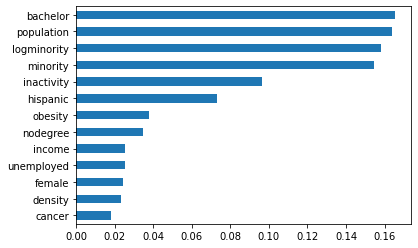

In [49]:
pd.Series(rf1.feature_importances_,index=list(Xtrain)).sort_values().plot(kind="barh")

Since our response isn't very symmetric, we may want to suppress outliers by using the `mean_absolute_error` instead. 

In [50]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, rf1.predict(Xtest))

11.960096476655815